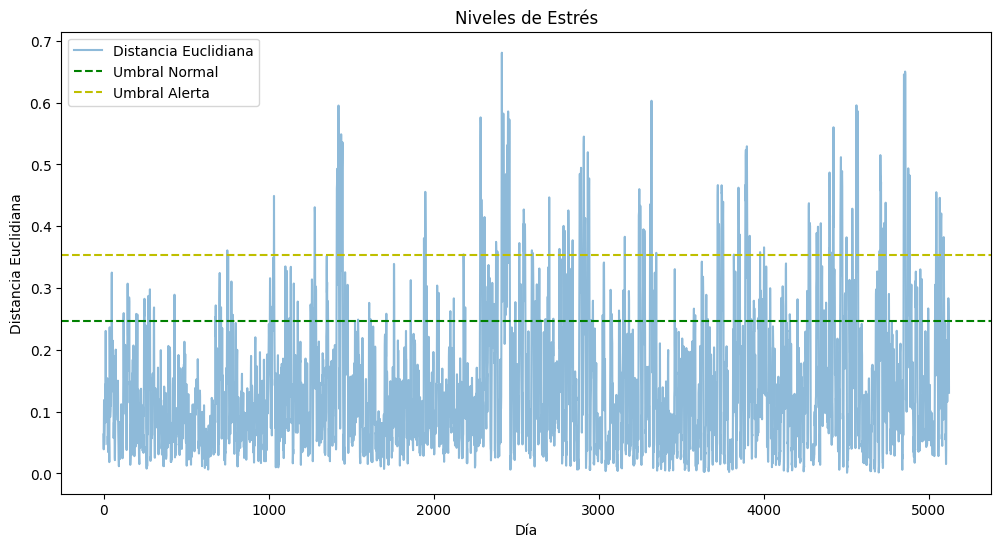

           Fecha  Hora  distancia nivel_estres
0     2024-01-01    12   0.063177       normal
1     2024-01-01    13   0.039120       normal
2     2024-01-01    14   0.082551       normal
3     2024-01-01    15   0.118807       normal
4     2024-01-01    16   0.046209       normal
...          ...   ...        ...          ...
5120  2024-11-21    20   0.283454       alerta
5121  2024-11-21    21   0.270910       alerta
5122  2024-11-21    22   0.245988       normal
5123  2024-11-21    23   0.211777       normal
5124  2024-11-22     0   0.130589       normal

[5125 rows x 4 columns]


C:\Users\PC\AppData\Local\Temp\ipykernel_10656\1946938308.py:110: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_resampled = df['nivel_actividad'].resample('h').mean().fillna(method='ffill')


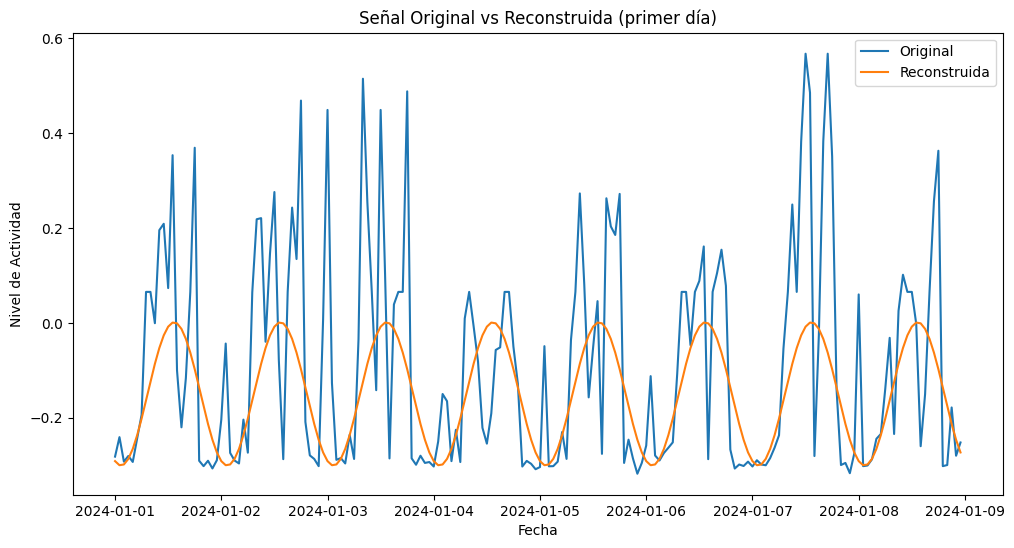

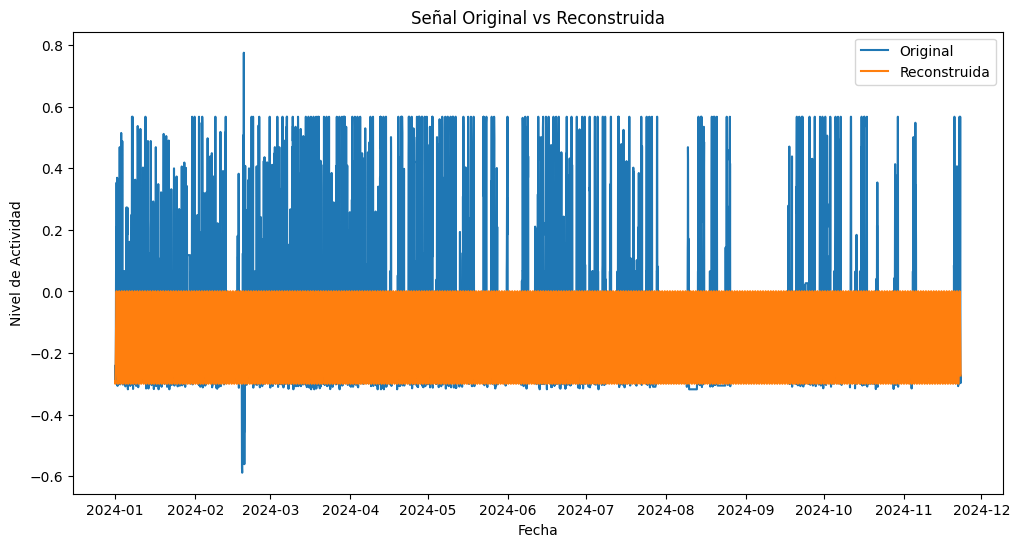

In [18]:
import pandas as pd 
import numpy as np
from scipy.fft import fft, ifft
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.fft import fft
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

# Función para calcular el ciclo circadiano utilizando la Transformada de Fourier
def extract_circadian_cycle(data, sample_rate=24, z=1):
    
    fft_result = fft(data)
    n = len(data)
    freq = np.fft.fftfreq(n, d=1/sample_rate)
    
    # Mantener solo los armónicos en el rango [-z, z]
    fft_filtered = np.zeros_like(fft_result, dtype=complex)
    for k in range(-z, z + 1):
        idx = np.argmin(np.abs(freq - k))  # Encuentra el índice más cercano a la frecuencia k
        fft_filtered[idx] = fft_result[idx]
    
    # Reconstrucción de la señal para obtener el ciclo circadiano
    return np.real(ifft(fft_filtered))

# Función para procesar una columna de actividad y calcular niveles de estrés
def process_activity(df, activity_column):
    # Crear ventanas móviles de 36 horas con paso de 1 hora
    window_size = 36
    step_size = 1

    series_results = []
    for start_idx in range(0, len(df) - window_size + 1, step_size):
        window_data = df.iloc[start_idx:start_idx + window_size]
        if len(window_data) == window_size:
            # Subseries A y B de 24 horas con desfase de 12 horas
            subseries_A = window_data.iloc[:24]
            subseries_B = window_data.iloc[12:36]
            
            # Extraer ciclos circadianos
            cycle_A = extract_circadian_cycle(subseries_A[activity_column].values)
            cycle_B = extract_circadian_cycle(subseries_B[activity_column].values)
            # Sincronizar modelos considerando el desfase de 12 horas
            synced_A = {i: cycle_A[i] for i in range(12, 24)}  # Ciclo A desde la hora 12 a 23
            synced_B = {i+12: cycle_B[i] for i in range(0, 12)}  # Ciclo B desde la hora 0 a 12
            
            # Comparar ciclos sincronizados (clave a clave)
            differences = []
            for key in synced_A:
                
                if key in synced_B:  # Verificar que exista la clave en ambos ciclos
                    differences.append((synced_A[key] - synced_B[key]) ** 2)
                    #print(differences)
                else:
                    differences.append(np.abs(synced_A[key] - 0))
            
            # Calcular distancia euclidiana acumulada
            dist_euclidiana = np.sqrt(sum(differences))
            #print(dist_euclidiana)
            
            # Almacenar resultados
            series_results.append({
                'Fecha': window_data.index[12].date(),
                'Hora': window_data.index[12].hour,
                'distancia': dist_euclidiana
            })
            # print(series_results)
            # print(window_data.index[12].hour)
            # Plotting
            # plt.figure(figsize=(18, 6))
            # hours = range(36)
            # plt.plot(hours, (window_data[activity_column].values), label="Nivel de actividad (Original)", linestyle='-', alpha=0.8)
            # plt.plot(range(24), cycle_A, 'k--', label="Ciclo A")
            # plt.plot(range(12, 36), cycle_B, 'k--', label="Ciclo B")
            # plt.title("Serie de 36 horas con ciclo circadiano A y B de 24 Horas")
            # plt.xlabel("Horas")
            # plt.ylabel("Nivel de actividad")
            # plt.legend()
            # plt.grid(True)
            # plt.show()

    # Guardar resultados como DataFrame
    distance_df = pd.DataFrame(series_results)
    
    # Establecer umbrales de estrés usando desviación estándar
    mean_dist = distance_df['distancia'].mean()
    std_dist = distance_df['distancia'].std()
    threshold1 = mean_dist + std_dist
    threshold2 = mean_dist + 2 * std_dist
    
    # Clasificación de niveles de estrés basada en los umbrales
    def get_stress_level(distance):
        if distance <= threshold1:
            return 'normal'
        elif distance <= threshold2:
            return 'alerta'
        else:
            return 'peligro'

    # Aplicar la función de nivel de estrés a cada distancia
    distance_df['nivel_estres'] = distance_df['distancia'].apply(get_stress_level)
    grafica_niveles(distance_df,threshold1,threshold2)
    
    return distance_df[['Fecha', 'Hora','distancia', 'nivel_estres']]
    
def grafica_ciclos(df,activity_column):
    # Resampling a frecuencia horaria (por si acaso hay datos faltantes)
    df_resampled = df['nivel_actividad'].resample('h').mean().fillna(method='ffill')
    ciclos = extract_circadian_cycle(df_resampled.values)
    ventana=192
    # Plotear la señal original y la reconstruida para el primer día
    plt.figure(figsize=(12, 6))
    plt.plot(df_resampled.index[:ventana], df_resampled.values[:ventana], label='Original')
    plt.plot(df_resampled.index[:ventana], ciclos[:ventana], label='Reconstruida')
    plt.title('Señal Original vs Reconstruida (primer día)')
    plt.xlabel('Fecha')
    plt.ylabel('Nivel de Actividad')
    plt.legend()
    plt.show()

    # Plotear la señal original y la reconstruida
    plt.figure(figsize=(12, 6))
    plt.plot(df_resampled.index, df_resampled.values, label='Original')
    plt.plot(df_resampled.index, ciclos, label='Reconstruida')
    plt.title('Señal Original vs Reconstruida')
    plt.xlabel('Fecha')
    plt.ylabel('Nivel de Actividad')
    plt.legend()
    plt.show()
    
def grafica_niveles(distance_df,threshold1,threshold2):
    # Crear la gráfica de líneas
    plt.figure(figsize=(12, 6))
    plt.plot(distance_df['distancia'], label='Distancia Euclidiana', alpha=0.5)
    plt.axhline(y=threshold1, color='g', linestyle='--', label='Umbral Normal')
    plt.axhline(y=threshold2, color='y', linestyle='--', label='Umbral Alerta')
    #plt.axhline(y=threshold3_2, color='r', linestyle='--', label='Umbral Peligro')
    plt.title('Niveles de Estrés')
    plt.xlabel('Día')
    plt.ylabel('Distancia Euclidiana')
    plt.legend()
    plt.show()
         
# Configuración de datos de entrada
nombres_csv ={4}# {1, 2, 3, 4, 468, 479, 4003, 4151, 4160, 4173}
for nombre_csv in nombres_csv:
    df = pd.read_csv(f'../Datos_actividad/{nombre_csv}_act.csv')
    # fecha_limite = '2024-01-02'
    # df = data[data['Fecha'] <= fecha_limite].copy()
    # Convertir 'Fecha' y 'Hora' a datetime e indexar el DataFrame
    df['datetime'] = pd.to_datetime(df['Fecha'] + ' ' + df['Hora'].astype(str) + ':00:00')
    df = df.set_index('datetime')
    df = df.sort_index()
    
    # Procesar  columnas de actividad y calcular niveles de estrés
    stress_levels = process_activity(df, 'nivel_actividad')
    print (stress_levels)
    grafica_ciclos(df,'nivel_actividad')
    
